In [1]:
import os
os.chdir(os.getcwd().replace("\\notebooks", ""))

In [7]:
import datetime
import random

import pandas as pd
import matplotlib.dates as mdates
from matplotlib import pyplot as plt
from tqdm import tqdm

from savings_plan_projecter.simulating import NctDistribution, CrisisCounter

from savings_plan_projecter.config import load_config

from savings_plan_projecter.days import date_range
from savings_plan_projecter.wallet import Wallet

from savings_plan_projecter.plotting import new_plot

In [3]:
config = load_config()

In [4]:
crisis_params = config.get_distribution_parameters("S&P500", "crisis")
crisis_distr = NctDistribution(*crisis_params)

regular_params = config.get_distribution_parameters("S&P500", "regular")
regular_distr = NctDistribution(*regular_params)

In [36]:
def _constraint_variation(variation: float) -> float:
    return min(max(variation, -0.3), 0.3)

savings_plan_duration_days = 365 * 4
total_duration_days = 365 * 5

simulations_crisis_in_4_months = []
CrisisCounter.MIN_DAYS_CRISIS_STARTS = 365

for _ in tqdm(range(1000)):

    wallet = Wallet()
    wallet.buy("S&P500", 600)

    logs = {
        "date": [],
        "is_working_day": [],
        "is_first_working_day_of_month": [],
        "is_crisis": [],
        "crisis_counter": [],
        "wallet_countervalue": [],
        "wallet_investment": [],
        "wallet_return": [],
    }
    crisis_counter = CrisisCounter()


    
    for index, day in enumerate(date_range(datetime.date.today(), total_duration_days)):
        
        crisis_counter.update(index)
        
        if day.is_first_working_day_of_month and index <= savings_plan_duration_days:
            wallet.buy("S&P500", 300)
        if day.is_working_day:
            if crisis_counter.in_crisis:
                wallet.apply_percentage_value_change("S&P500", _constraint_variation(crisis_distr.rvs(1)[0] / 100))
            else:
                wallet.apply_percentage_value_change("S&P500", _constraint_variation(regular_distr.rvs(1)[0] / 100))
                
        logs["date"].append(day.date)
        logs["is_working_day"].append(day.is_working_day)
        logs["is_first_working_day_of_month"].append(day.is_first_working_day_of_month)
        logs["is_crisis"].append(crisis_counter.in_crisis)
        logs["crisis_counter"].append(crisis_counter.days_in_crisis)
        logs["wallet_countervalue"].append(wallet.countervalue)
        logs["wallet_investment"].append(wallet.investment)
        logs["wallet_return"].append(wallet.return_on_investment)
    
    simulations_crisis_in_4_months.append(logs)


100%|██████████| 1000/1000 [03:20<00:00,  5.00it/s]


In [26]:
returns = pd.Series([
    simulation["wallet_return"][-1] * 100 for simulation in simulations_crisis_in_4_months
])

In [27]:
returns.name = "5-years return (%)"
returns.to_csv("data/output/returns_crisis_in_12_months_4_years_pac.csv", index=False)

In [29]:
returns.describe()

count    1000.000000
mean       25.132062
std        47.471290
min       -79.037560
25%        -8.880019
50%        18.736315
75%        50.498317
max       232.390176
Name: 5-years return (%), dtype: float64

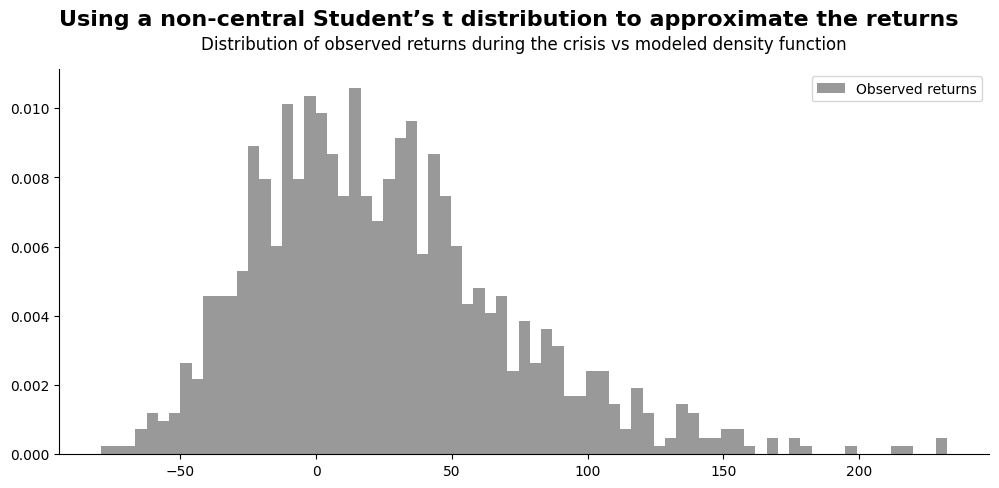

In [28]:
fig, ax = new_plot(
    title="Using a non-central Student’s t distribution to approximate the returns",
    subtitle="Distribution of observed returns during the crisis vs modeled density function"
)

ax.hist(returns, bins=75, density=True, color="grey", alpha=0.8, label="Observed returns")
ax.legend()

plt.show()

In [11]:
df = pd.DataFrame(logs)
df.columns = df.columns.str.upper()
df.head(1)

,DATE,IS_WORKING_DAY,IS_FIRST_WORKING_DAY_OF_MONTH,IS_CRISIS,CRISIS_COUNTER,WALLET_COUNTERVALUE,WALLET_INVESTMENT,WALLET_RETURN
0,2023-06-04,False,False,False,0,600.0,600,0.0


In [33]:
df = pd.DataFrame(logs)
df.columns = df.columns.str.upper()

[]

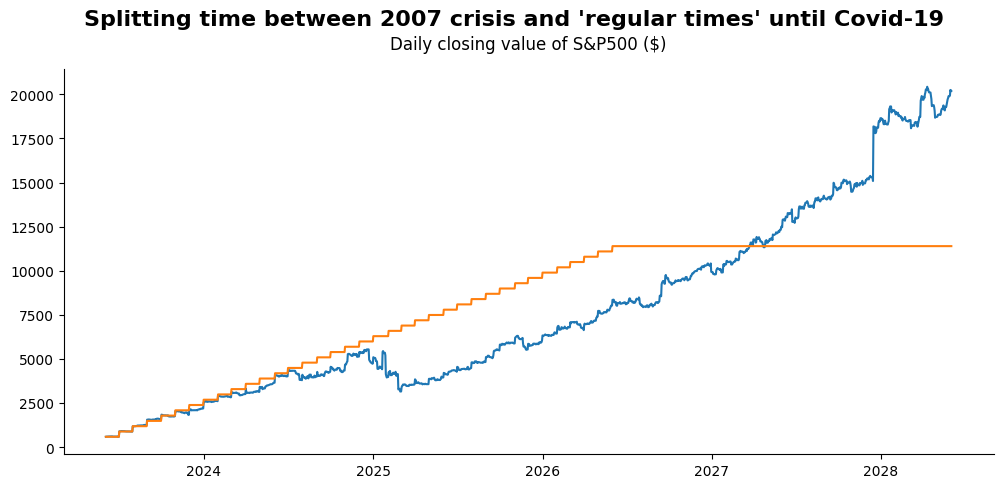

In [34]:
_, ax = new_plot(
    title="Splitting time between 2007 crisis and 'regular times' until Covid-19",
    subtitle="Daily closing value of S&P500 ($)",
    figsize=(12, 5),
)


ax.plot(
    pd.to_datetime(df.DATE),
    df.WALLET_COUNTERVALUE,
)

ax.plot(
    pd.to_datetime(df.DATE),
    df.WALLET_INVESTMENT,
)

ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.plot()

[]

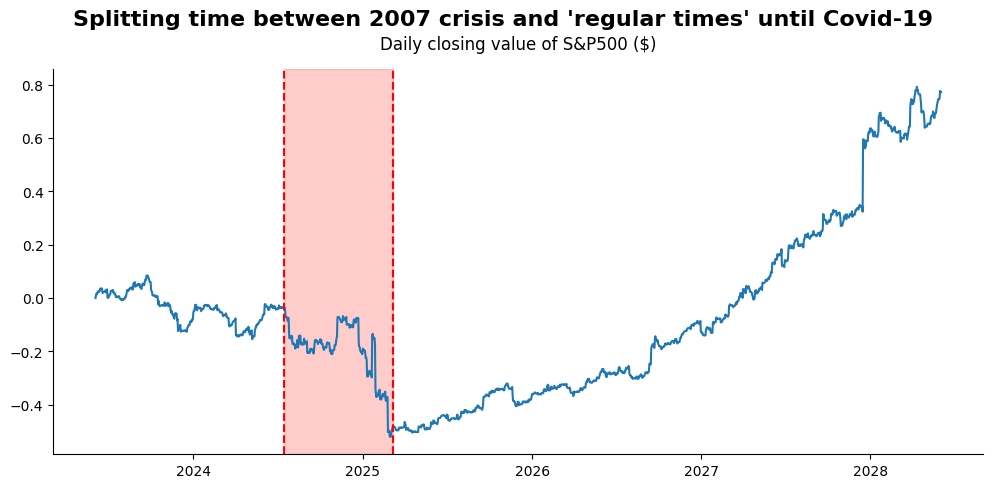

In [35]:
_, ax = new_plot(
    title="Splitting time between 2007 crisis and 'regular times' until Covid-19",
    subtitle="Daily closing value of S&P500 ($)",
    figsize=(12, 5),
)


ax.plot(
    pd.to_datetime(df.DATE),
    df.WALLET_RETURN,
)

crisis_start_date = df.loc[df.IS_CRISIS, "DATE"].min()
crisis_end_date = df.loc[df.IS_CRISIS, "DATE"].max()

ax.axvline(crisis_start_date, c="red", ls="dashed")
ax.axvline(crisis_end_date, c="red", ls="dashed")
ax.axvspan(xmin=crisis_start_date, xmax=crisis_end_date, color="red", alpha=0.2)

ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.plot()

In [14]:
df

,DATE,IS_WORKING_DAY,IS_FIRST_WORKING_DAY_OF_MONTH,IS_CRISIS,CRISIS_COUNTER,WALLET_COUNTERVALUE,WALLET_INVESTMENT,WALLET_RETURN
0,2023-06-04,False,False,False,0,600.000000,600,0.000000
1,2023-06-05,True,False,False,0,602.899879,600,0.004833
2,2023-06-06,True,False,False,0,605.118537,600,0.008531
3,2023-06-07,True,False,False,0,601.766360,600,0.002944
4,2023-06-08,True,False,False,0,605.255792,600,0.008760
...,...,...,...,...,...,...,...,...
1820,2028-05-28,False,False,False,276,24554.661207,11400,1.153918
1821,2028-05-29,True,False,False,276,25017.571744,11400,1.194524
1822,2028-05-30,True,False,False,276,25232.562456,11400,1.213383
1823,2028-05-31,True,False,False,276,25180.922666,11400,1.208853
